## Fine-tune TrOCR on the IAM Handwriting Database

We will do this using the new `VisionEncoderDecoderModel` class, which can be used to combine any image Transformer encoder (such as ViT, BEiT) with any text Transformer as decoder (such as BERT, RoBERTa, GPT-2). TrOCR is an instance of this, as it has an encoder-decoder architecture, with the weights of the encoder initialized from a pre-trained BEiT, and the weights of the decoder initialized from a pre-trained RoBERTa. The weights of the cross-attention layer were randomly initialized, before the authors pre-trained the model further on millions of (partially synthetic) annotated images of handwritten text. 

This figure gives a good overview of the model (from the original paper):

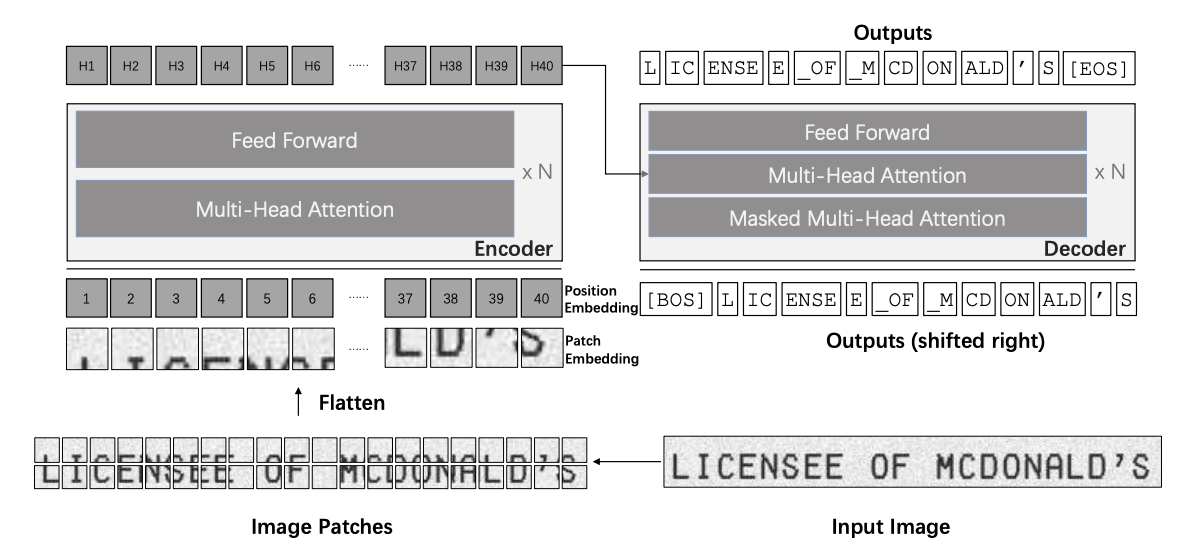

* TrOCR paper: https://arxiv.org/abs/2109.10282
* TrOCR documentation: https://huggingface.co/transformers/master/model_doc/trocr.html


Note that Patrick also wrote a very good [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder) on warm-starting encoder-decoder models (which is what the TrOCR authors did). This blog post was very helpful for me to create this notebook. 

We will fine-tune the model using the Seq2SeqTrainer, which is a subclass of the 🤗 Trainer that lets you compute generative metrics such as BLEU, ROUGE, etc by doing generation (i.e. calling the `generate` method) inside the evaluation loop.



## Set-up environment

First, let's install the required libraries:
* Transformers (for the TrOCR model)
* Datasets & Jiwer (for the evaluation metric)

## Installing Libraries

In [ ]:
!nvidia-smi

Thu Jul  7 14:57:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers==4.18.0 datasets jiwer huggingface_hub sentencepiece torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 5.0 MB/s 
     |████████████████████████████████| 362 kB 68.5 MB/s 
     |████████████████████████████████| 101 kB 8.3 MB/s 
     |████████████████████████████████| 1.2 MB 68.5 MB/s 
     |████████████████████████████████| 880 kB 57.5 MB/s 
     |████████████████████████████████| 596 kB 70.4 MB/s 
     |████████████████████████████████| 6.6 MB 40.5 MB/s 
     |████████████████████████████████| 212 kB 98.1 MB/s 
     |████████████████████████████████| 140 kB 95.6 MB/s 
     |████████████████████████████████| 1.1 MB 77.3 MB/s 
     |████████████████████████████████| 127 kB 61.9 MB/s 
     |████████████████████████████████| 50 kB 4.6 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 144 kB 97.2 MB/s 
     |████████████████████████████████| 271 kB 65.9 MB/s 
  Created wheel for python-Levenshtei

In [ ]:
encoder = "facebook/deit-base-distilled-patch16-224"
decoder = "UBC-NLP/ARBERT"
model_name = "./ArOCRv5"

## Prepare data

We first download the data. Here, I'm just using the IAM test set, as this was released by the TrOCR authors in the unilm repository. It can be downloaded from [this page](https://github.com/microsoft/unilm/tree/master/trocr). 

Let's make a [regular PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We first create a Pandas dataframe with 2 columns. Each row consists of the file name of an image, and the corresponding text.

Here we will be downloading the dataset from Khaat Online

In [ ]:
from datasets import load_dataset

train_df1 = load_dataset("gagan3012/adab",split="train")
test_df1 = load_dataset("gagan3012/adab",split="valid")
pred_df1 = load_dataset("gagan3012/adab",split="test")

Downloading:   0%|          | 0.00/930 [00:00<?, ?B/s]

Using custom data configuration gagan3012--adab-8162139264bfb833


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/gagan3012___parquet/gagan3012--adab-8162139264bfb833/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8. Subsequent calls will reuse this data.


Using custom data configuration gagan3012--adab-8162139264bfb833
Reusing dataset parquet (/root/.cache/huggingface/datasets/gagan3012___parquet/gagan3012--adab-8162139264bfb833/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)
Using custom data configuration gagan3012--adab-8162139264bfb833
Reusing dataset parquet (/root/.cache/huggingface/datasets/gagan3012___parquet/gagan3012--adab-8162139264bfb833/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


In [ ]:
from datasets import load_dataset

train_df2 = load_dataset("gagan3012/OnlineKhatt",split="train")
test_df2 = load_dataset("gagan3012/OnlineKhatt",split="test+dev")

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Using custom data configuration gagan3012--OnlineKhatt-e66084177a1d53f0


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/gagan3012___parquet/gagan3012--OnlineKhatt-e66084177a1d53f0/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8. Subsequent calls will reuse this data.


Using custom data configuration gagan3012--OnlineKhatt-e66084177a1d53f0
Reusing dataset parquet (/root/.cache/huggingface/datasets/gagan3012___parquet/gagan3012--OnlineKhatt-e66084177a1d53f0/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


In [ ]:
import pandas as pd
dataset_train = pd.DataFrame(train_df1)
dataset_test = pd.DataFrame(test_df1)
dataset_pred = pd.DataFrame(pred_df1)

In [ ]:
dataset_train.head()

,image,text
0,<PIL.TiffImagePlugin.TiffImageFile image mode=...,ملّيتة
1,<PIL.TiffImagePlugin.TiffImageFile image mode=...,بئر الطّيب
2,<PIL.TiffImagePlugin.TiffImageFile image mode=...,السوق الجديد
3,<PIL.TiffImagePlugin.TiffImageFile image mode=...,المطوية
4,<PIL.TiffImagePlugin.TiffImageFile image mode=...,جنورة


In [ ]:
dataset_test.head()

,image,text
0,<PIL.TiffImagePlugin.TiffImageFile image mode=...,الوسلاتيّة
1,<PIL.TiffImagePlugin.TiffImageFile image mode=...,الرديف
2,<PIL.TiffImagePlugin.TiffImageFile image mode=...,الغابات
3,<PIL.TiffImagePlugin.TiffImageFile image mode=...,نكتة
4,<PIL.TiffImagePlugin.TiffImageFile image mode=...,فرنانة


We split up the data into training + testing, using sklearn's `train_test_split` function.

Each element of the dataset should return 2 things:
* `pixel_values`, which serve as input to the model.
* `labels`, which are the `input_ids` of the corresponding text in the image.

We use `TrOCRProcessor` to prepare the data for the model. `TrOCRProcessor` is actually just a wrapper around a `ViTFeatureExtractor` (which can be used to resize + normalize images) and a `RobertaTokenizer` (which can be used to encode and decode text into/from `input_ids`).

Let's initialize the training and evaluation datasets:

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class OCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        #file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = self.df['image'][idx].convert("RGB")
        #image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
from transformers import TrOCRProcessor, AutoFeatureExtractor, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(decoder)

feature_extractor = AutoFeatureExtractor.from_pretrained(encoder)

processor = TrOCRProcessor(feature_extractor,tokenizer)
train_dataset = OCRDataset(root_dir='',
                           df=dataset_train,
                           processor=processor)
eval_dataset = OCRDataset(root_dir='',
                           df=dataset_test,
                           processor=processor)
pred_dataset = OCRDataset(root_dir='',
                           df=dataset_pred,
                           processor=processor)

Downloading:   0%|          | 0.00/374 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 13525
Number of validation examples: 751


Let's verify an example from the training dataset:

In [ ]:
encoding = train_dataset[1]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 224, 224])
labels torch.Size([128])


We can also check the original image and decode the labels:

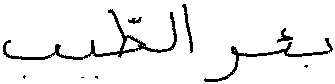

In [ ]:
image =  dataset_train['image'][1]
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

بير الطيب


In [ ]:
set(dataset_train.text.sum())


{' ',
 '0',
 '1',
 '2',
 '6',
 '7',
 '8',
 '9',
 'V',
 'ء',
 'آ',
 'أ',
 'إ',
 'ئ',
 'ا',
 'ب',
 'ة',
 'ت',
 'ث',
 'ج',
 'ح',
 'خ',
 'د',
 'ذ',
 'ر',
 'ز',
 'س',
 'ش',
 'ص',
 'ض',
 'ط',
 'ظ',
 'ع',
 'غ',
 'ف',
 'ق',
 'ك',
 'ل',
 'م',
 'ن',
 'ه',
 'و',
 'ى',
 'ي',
 'ّ'}

## Train a model

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    encoder, decoder
)

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTModel: ['distillation_classifier.bias', 'cls_classifier.bias', 'distillation_classifier.weight', 'cls_classifier.weight']
- This IS expected if you are initializing DeiTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.weight', 'deit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at UBC-NLP/ARBERT were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at UBC-NLP/ARBERT and are newly initialized: ['bert.encoder.layer.4.crossattention.self.query.weight', 'bert.encoder.layer.10.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.

Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    fp16=True,
#     adam_beta1=0.9,
#     adam_beta2=0.999,
#     adam_epsilon=1e-08,
    num_train_epochs=10,
#     weight_decay=0.005,
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
    do_train=True,
    do_eval=True,
    do_predict=True,
    output_dir ="./",
    save_total_limit=2,
)

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [ ]:
!sudo apt-get install git-lfs
!git lfs install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.


In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()
metrics = trainer.evaluate(metric_key_prefix="eval")
predict_results = trainer.predict(
            pred_dataset,
            metric_key_prefix="predict",
)
predictions = processor.batch_decode(
                    predict_results.predictions,
                    skip_special_tokens=True,
                    clean_up_tokenization_spaces=True,
)
predictions = [pred.strip() for pred in predictions]
print(predictions)

Using amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 13525
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 8460


Epoch,Training Loss,Validation Loss,Cer
1,1.932300,0.385725,0.213861
2,0.201000,0.124916,0.082489
3,0.067100,0.076246,0.055797
4,0.030900,0.068443,0.049686
5,0.010900,0.035924,0.027496
6,0.007600,0.031205,0.026210
7,0.004900,0.028866,0.041807
8,0.001300,0.025078,0.047596
9,0.000200,0.025011,0.047274
10,0.000000,0.024620,0.047274


***** Running Evaluation *****
  Num examples = 751
  Batch size = 16
Saving model checkpoint to ./checkpoint-846
Configuration saved in ./checkpoint-846/config.json
Model weights saved in ./checkpoint-846/pytorch_model.bin
Feature extractor saved in ./checkpoint-846/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 751
  Batch size = 16
Saving model checkpoint to ./checkpoint-1692
Configuration saved in ./checkpoint-1692/config.json
Model weights saved in ./checkpoint-1692/pytorch_model.bin
Feature extractor saved in ./checkpoint-1692/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 751
  Batch size = 16
Saving model checkpoint to ./checkpoint-2538
Configuration saved in ./checkpoint-2538/config.json
Model weights saved in ./checkpoint-2538/pytorch_model.bin
Feature extractor saved in ./checkpoint-2538/preprocessor_config.json
Deleting older checkpoint [checkpoint-846] due to args.save_total_limit
***** Running Evaluation *****
  Num exam

***** Running Prediction *****
  Num examples = 752
  Batch size = 16


['قصر هلال الرياض', 'مديونة', 'حزق', 'منزل تميم', 'تونس حشاد', 'مزدور', 'بير مشارقة', 'المزونة', 'منزل حر', 'حي هلال', 'تالة الجنوبية', 'قرطاج ياسمينة', 'الزهراء تطاوين', 'عين بومرة', 'مركز درويش', 'بوعثمان', 'السواسي', 'اركو', 'مقرن', 'متلوي المناجم', 'منزل حشاد', 'براكة الساحل', 'العلاية', 'اكودة', 'سيدي عساكر', 'ام التمر', 'اوتيك', 'المنزه 6', 'فدان السوق', 'رمادة', 'ليماقس', 'دوالي قفصة', 'شواط', 'صفاقس', 'بوعوان', 'صفاقس الجديدة', 'تونس هيبون', 'وادي الزيت', 'بوهلال الجنوبية', 'وادي باجة', 'الجرف', 'ذراع بن جودر', 'بازينة', 'ورغش', 'سوسة الرياض', 'بشلي', 'منزل بوزيان', 'بنزرت حشاد', 'تونس ساداكس', 'القريعات', 'وادي باجة', 'طبابة', 'السبالة', 'سيدي حمادة', 'القلعة الصغرى', 'الدندان', 'القرية راس الجبل', 'شتاوة صحراوي', 'صبيح', 'شط مريم', 'مزراية', 'تستور', 'القلعة الصغرى', 'بلاد الحضر', 'اولاد حفوز', 'تونس جباري', 'بن سالم', 'منزل ميمون', 'الرقبة', 'نبر', 'مركز سحنون', 'جبل الوسط', 'الساقية', 'كوتين', 'بوهلال', 'الصمعة', 'القتمة', 'تالة', 'سيدي بولبابة', 'فوشانة', 'قرقنة', 'اولاد ف

In [ ]:
predict_results.metrics

{'predict_cer': 0.015513897866839044,
 'predict_loss': 0.0176090057939291,
 'predict_runtime': 30.641,
 'predict_samples_per_second': 24.542,
 'predict_steps_per_second': 1.534}

In [ ]:
processor.save_pretrained(model_name)
trainer.save_model(model_name)

Feature extractor saved in ./ArOCRv5/preprocessor_config.json
tokenizer config file saved in ./ArOCRv5/tokenizer_config.json
Special tokens file saved in ./ArOCRv5/special_tokens_map.json
Saving model checkpoint to ./ArOCRv5
Configuration saved in ./ArOCRv5/config.json
Model weights saved in ./ArOCRv5/pytorch_model.bin
Feature extractor saved in ./ArOCRv5/preprocessor_config.json


PRED:  قصر هلال الرياض
GT:  قصر هلال الرّياض


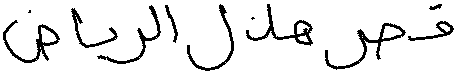

In [ ]:
print("PRED:  "+predictions[0])
print("GT:  "+dataset_pred['text'][0])
dataset_pred['image'][0]

In [ ]:
dataset_pred['text'][0]

'قصر هلال الرّياض'

In [ ]:
predictions[0]

'قصر هلال الرياض'

In [ ]:
processor.save_pretrained(model_name)
# trainer.push_to_hub()

Feature extractor saved in ./ArOCRv5/preprocessor_config.json
tokenizer config file saved in ./ArOCRv5/tokenizer_config.json
Special tokens file saved in ./ArOCRv5/special_tokens_map.json


## Inference

Note that after training, you can easily load the model using the .`from_pretrained(output_dir)` method.

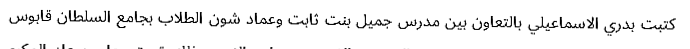

In [ ]:
import requests
from PIL import Image

url = "https://github.com/gagan3012/notebooks/blob/master/capr2%20(1).png?raw=true"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

## Prepare image for model

Next, we use `TrOCRProcessor` (which wraps a `ViTFeatureExtractor` and a `RobertaTokenizer` into one) to resize + normalize the image for the model.

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("./ArOCRv5")
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)

loading feature extractor configuration file ./ArOCRv5/preprocessor_config.json
Feature extractor DeiTFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "DeiTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "processor_class": "TrOCRProcessor",
  "resample": 3,
  "size": 256
}

Didn't find file ./ArOCRv5/added_tokens.json. We won't load it.
loading file ./ArOCRv5/vocab.txt
loading file ./ArOCRv5/tokenizer.json
loading file None
loading file ./ArOCRv5/special_tokens_map.json
loading file ./ArOCRv5/tokenizer_config.json


torch.Size([1, 3, 224, 224])


## Load model

Here we load the model from the hub.

In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("./ArOCRv5")

loading configuration file ./ArOCRv5/config.json
Model config VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "UBC-NLP/ARBERT",
    "add_cross_attention": true,
    "architectures": [
      "BertForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "directionality": "bidi",
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "gradient_checkpointing": false,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 768,
    "id2label": {
      "0": "LABEL

In [ ]:
model.cuda()

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0): DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=

In [ ]:
from torchsummary import summary
model.cuda()
# print(summary(model, (3, 224, 224), device='cuda',batch_size=-1))

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0): DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=

## Generate text 

Finally, we can generate text autoregressively using the `.generate()` method. We use the tokenizer part of the `processor` to decode the generated id's back to text. Note that by default, greedy search is used for generation, but there are more fancy methods like beam search and top-k sampling, which are also supported. You can check out [this blog post](https://huggingface.co/blog/how-to-generate) for details.

In [ ]:
pixel_values

tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-0.0116,  2.1462,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [-0.0116,  2.1462,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [-0.0116,  2.1462,  2.2489,  ...,  2.2489,  2.2489,  2.2489]],

         [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          ...,
          [ 0.1176,  2.3235,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 0.1176,  2.3235,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
          [ 0.1176,  2.3235,  2.4286,  ...,  2.4286,  2.4286,  2.4286]],

         [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
          [ 2.6400,  2.6400,  

In [ ]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

RuntimeError: ignored

In [ ]:
image